# EIP3 Phase2 Final Project

**Submitted by Zoheb Abai**

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape 
from keras.layers import Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

Using TensorFlow backend.


## Let's first build our VAE model

In [0]:
class VariationalAutoencoder():
  def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, 
               encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size, 
               decoder_conv_t_strides, z_dim, use_dropout= False):
    self.name = 'variational_autoencoder'
    
    self.input_dim = input_dim # size of input image
    self.encoder_conv_filters = encoder_conv_filters # encoder conv layers depth
    self.encoder_conv_kernel_size = encoder_conv_kernel_size # encoder conv kernel size
    self.encoder_conv_strides = encoder_conv_strides # encoder conv strides
    self.decoder_conv_t_filters = decoder_conv_t_filters # decoder conv transpose layers depth
    self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size # decoder conv kernel size
    self.decoder_conv_t_strides = decoder_conv_t_strides # decoder conv strides
    self.z_dim = z_dim # dimension of latent space
    self.use_dropout = use_dropout # use dropouts or not
    
    self.n_layers_encoder = len(encoder_conv_filters) # number of encoder conv layers
    self.n_layers_decoder = len(decoder_conv_t_filters) # number of decoder conv transpose layers
    
    self._build()

  
  ## BUILD THE FULL VAE MODEL
  def _build(self):
    
    # THE ENCODER 
    # A model that takes an input image and encodes it into the 2D latent space, 
    # by sampling a point from the normal distribution defined by mu and log_var.”

    encoder_input = Input(shape=self.input_dim, name='encoder_input')
    x = encoder_input
    
    for i in range(self.n_layers_encoder):
      conv_layer = Conv2D(filters = self.encoder_conv_filters[i], 
                          kernel_size = self.encoder_conv_kernel_size[i], 
                          strides = self.encoder_conv_strides[i], 
                          padding = 'same', name = 'encoder_conv_' + str(i))
      x = conv_layer(x)
      x = BatchNormalization()(x)
      x = LeakyReLU()(x)
      if self.use_dropout:
        x = Dropout(rate = 0.25)(x)
      
    shape_before_flattening = K.int_shape(x)[1:]
    x = Flatten()(x)
    self.mu = Dense(self.z_dim, name='mu')(x)
    self.log_var = Dense(self.z_dim, name='log_var')(x)
    # We choose to map to the logarithm of the variance, as this can take any real 
    # number in the range (–inf, inf), matching the natural output range from a 
    # neural network unit, whereas variance values are always positive.

    self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

    # Now, since we are sampling a random point from an area around mu, the decoder 
    # must ensure that all points in the same neighborhood produce very similar images when 
    # decoded, so that the reconstruction loss remains small.

    def sampling(args):
      mu, log_var = args
      epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
      return mu + K.exp(log_var / 2) * epsilon

    # Latent space
    encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])
    
    self.encoder = Model(encoder_input, encoder_output)

    # THE DECODER
    # A model that takes a point in the latent space and decodes it into the original image domain.

    decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    for i in range(self.n_layers_decoder):
      conv_t_layer = Conv2DTranspose(filters = self.decoder_conv_t_filters[i], 
                                     kernel_size = self.decoder_conv_t_kernel_size[i], 
                                     strides = self.decoder_conv_t_strides[i], 
                                     padding = 'same', name = 'decoder_conv_t_' + str(i))

      x = conv_t_layer(x)
      if i < self.n_layers_decoder - 1: # condition for not having bn-leakyrelu-dropout at last layer
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        if self.use_dropout:
          x = Dropout(rate = 0.25)(x)
      else:
        x = Activation('sigmoid')(x)

    decoder_output = x
    self.decoder = Model(decoder_input, decoder_output)

    ### THE FULL VAE
    model_input = encoder_input
    model_output = self.decoder(encoder_output)

    self.model = Model(model_input, model_output)

  ## DEFINE THE LOSS FUNCTIONS AND OPTIMIZER
  def compile(self, learning_rate, reco_loss_factor):
    self.learning_rate = learning_rate
    # Binary cross-entropy places heavier penalties on predictions at the extremes 
    # that are badly wrong, so it tends to push pixel predictions to the middle of the 
    # range. This results in less vibrant images. For this reason, we use RMSE as the 
    # loss function.

    def vae_r_loss(y_true, y_pred):
      r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
      return reco_loss_factor * r_loss # reco_loss_factor ensures balance with the KL divergence loss

    # KL divergence term penalizes the network for encoding observations to mu 
    # and log_var variables that differ significantly from the parameters of a 
    # standard normal distribution, namely mu = 0 and log_var = 0.

    def vae_kl_loss(y_true, y_pred):
      kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
      return kl_loss

    def vae_loss(y_true, y_pred):
      reco_loss = vae_r_loss(y_true, y_pred)
      kl_loss = vae_kl_loss(y_true, y_pred)
      return  reco_loss + kl_loss

    optimizer = Adam(lr=learning_rate)
    self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])

## Import CelebA dataset

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

os.mkdir('data/')
!cp 'drive/My Drive/Dataset/img_align_celeba.zip' .
!unzip -qq 'img_align_celeba.zip' -d 'data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Define Parameters

In [0]:
from glob import glob

DATA_FOLDER = 'data/'
IMAGE_FOLDER = 'data/img_align_celeba/'
INPUT_DIM = (128,128,3)
BATCH_SIZE = 32
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 10000
EPOCHS = 30

## Data flow 

In [5]:
# Import libraries
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255)
data_flow = data_gen.flow_from_directory(DATA_FOLDER, target_size = INPUT_DIM[:2], 
                                         batch_size = BATCH_SIZE, shuffle = True, 
                                         class_mode = 'input')

Found 202599 images belonging to 1 classes.


## Define the Arch

In [6]:
vae = VariationalAutoencoder(input_dim = INPUT_DIM, 
                             encoder_conv_filters=[32,64,64,128,128,256], 
                             encoder_conv_kernel_size=[3,3,3,3,3,3], 
                             encoder_conv_strides=[2,2,2,2,2,2], 
                             decoder_conv_t_filters=[128,128,64,64,32,3], 
                             decoder_conv_t_kernel_size=[3,3,3,3,3,3], 
                             decoder_conv_t_strides=[2,2,2,2,2,2], 
                             z_dim=400, 
                             use_dropout=True)

W0825 12:38:26.715221 140129920313216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 12:38:26.778071 140129920313216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 12:38:26.815107 140129920313216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 12:38:26.832549 140129920313216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0825 12:38:26.833663 1401299203

## Encoder Model Summary 

In [7]:
vae.encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

## Decoder Model Summary

In [8]:
vae.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              410624    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 4, 4, 128)         295040    
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 128)         0         
__________

## Train the VAE Model

In [9]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

W0825 12:38:40.301044 140129920313216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    # Wrapper function to create a LearningRateScheduler with step decay schedule
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr= LEARNING_RATE, decay_factor=1, step_size=1)
checkpoint = ModelCheckpoint('data/weights.h5', save_weights_only = True, monitor='vae_loss', verbose=1)

In [12]:
vae.model.fit_generator(data_flow, shuffle = True, epochs = EPOCHS, 
                        steps_per_epoch = NUM_IMAGES // BATCH_SIZE,
                        callbacks = [checkpoint, lr_sched])

Epoch 1/30
6331/6331 [==============================] - 503s 80ms/step - loss: 324.1314 - vae_r_loss: 271.9852 - vae_kl_loss: 52.1463

Epoch 00001: saving model to data/weights.h5
Epoch 2/30
6331/6331 [==============================] - 501s 79ms/step - loss: 260.5898 - vae_r_loss: 214.0523 - vae_kl_loss: 46.5375

Epoch 00002: saving model to data/weights.h5
Epoch 3/30
6331/6331 [==============================] - 513s 81ms/step - loss: 252.6911 - vae_r_loss: 205.1249 - vae_kl_loss: 47.5663

Epoch 00003: saving model to data/weights.h5
Epoch 4/30
6331/6331 [==============================] - 518s 82ms/step - loss: 248.3647 - vae_r_loss: 200.1654 - vae_kl_loss: 48.1992

Epoch 00004: saving model to data/weights.h5
Epoch 5/30
6331/6331 [==============================] - 519s 82ms/step - loss: 245.9378 - vae_r_loss: 197.5380 - vae_kl_loss: 48.3998

Epoch 00005: saving model to data/weights.h5
Epoch 6/30
6331/6331 [==============================] - 519s 82ms/step - loss: 244.3252 - vae_r_loss

## Load the model for Generation

In [0]:
vae.model.load_weights('data/weights.h5')

**The latent space of the VAE is truly a continuous space that can be traversed and explored to generate a multitude of different human faces. Let's see some of its applications.**



## Newly generated faces

Generating faces from random latent space normal distribution

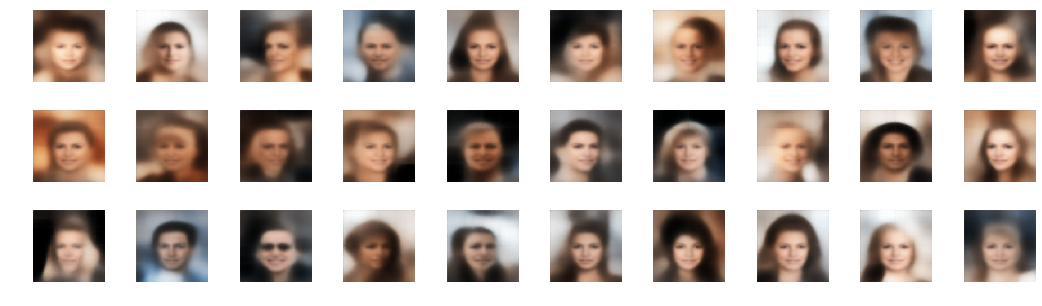

In [14]:
n_to_show = 30
znew = np.random.normal(size = (n_to_show,vae.z_dim))
reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')
plt.show()

## Reconstructing faces

Reconstructing faces from input images

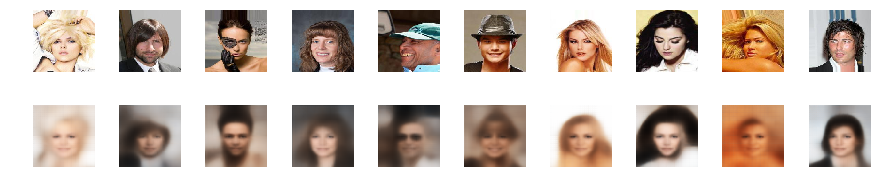

In [15]:
example_images= data_flow[0][0]
z_points = vae.encoder.predict(example_images)
reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(10):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, 10, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(10):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, 10, i+11)
    sub.axis('off')
    sub.imshow(img)

## Feature Manipulation

For features in dataset we add attributes related to the celebrity faces

In [17]:
import pandas as pd
attr = pd.read_csv('list_attr_celeba.csv')
attr.head()

File_name  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1

[5 rows x 41 columns]

### Functions for getting vectors for corresponding label

In [0]:
def get_vector_from_label(label, batch_size):
    
    data_gen = ImageDataGenerator(rescale=1./255)
    data_flow_label = data_gen.flow_from_dataframe(attr, IMAGE_FOLDER, 
                                                   x_col='File_name', 
                                                   y_col = label,
                                                   target_size=INPUT_DIM[:2] , 
                                                   class_mode='other', 
                                                   batch_size=batch_size, 
                                                   shuffle=True)

    # Initiating vectors 
    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : del distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        # For positive attributes
        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        # For negative attributes
        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector

In [19]:
# Respective attribute vectors
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 validated image filenames.
label: Attractive
images : POS move : NEG move :distance : del distance
263    : 1.31    : 1.288    : 1.968    : 1.968
523    : 0.868    : 0.908    : 1.499    : -0.469
782    : 0.465    : 0.508    : 1.386    : -0.114
1051    : 0.35    : 0.342    : 1.297    : -0.089
1306    : 0.257    : 0.281    : 1.227    : -0.07
1567    : 0.223    : 0.234    : 1.172    : -0.056
1842    : 0.2    : 0.194    : 1.127    : -0.045
2130    : 0.182    : 0.157    : 1.104    : -0.023
2360    : 0.132    : 0.156    : 1.085    : -0.02
2602    : 0.125    : 0.143    : 1.076    : -0.009
2842    : 0.11    : 0.125    : 1.056    : -0.019
3116    : 0.112    : 0.105    : 1.056    : -0.0
3357    : 0.094    : 0.109    : 1.043    : -0.013
3608    : 0.093    : 0.098    : 1.028    : -0.016
3860    : 0.081    : 0.093    : 1.016    : -0.012
4103    : 0.077    : 0.08    : 1.008    : -0.008
4370    : 0.079    : 0.076    : 1.004    : -0.004
4625    : 0.073    : 0.075    : 1.001    : -0.002
48

### Functions to apply arithmetic on latent space to add features on generated images

In [0]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]
    data_gen = ImageDataGenerator(rescale=1./255)
    data_flow_label = data_gen.flow_from_dataframe(attr, IMAGE_FOLDER, 
                                                   x_col='File_name', 
                                                   target_size=INPUT_DIM[:2] , 
                                                   class_mode='input', 
                                                   batch_size=n_to_show, 
                                                   shuffle=True)
    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()

Attractive Vector
Found 202599 validated image filenames.


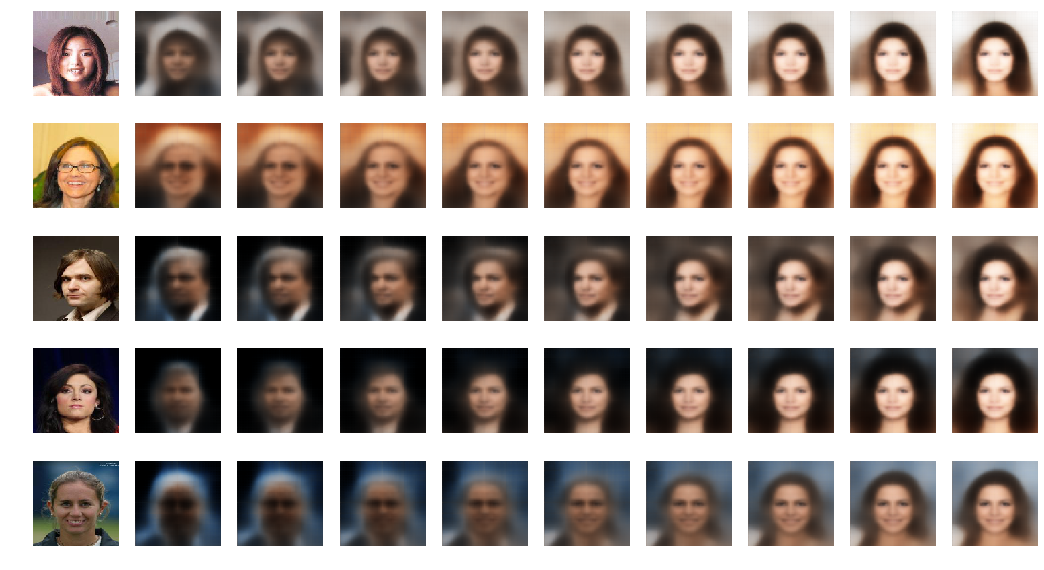

In [21]:
print('Attractive Vector')
add_vector_to_images(attractive_vec)

Mouth Open Vector
Found 202599 validated image filenames.


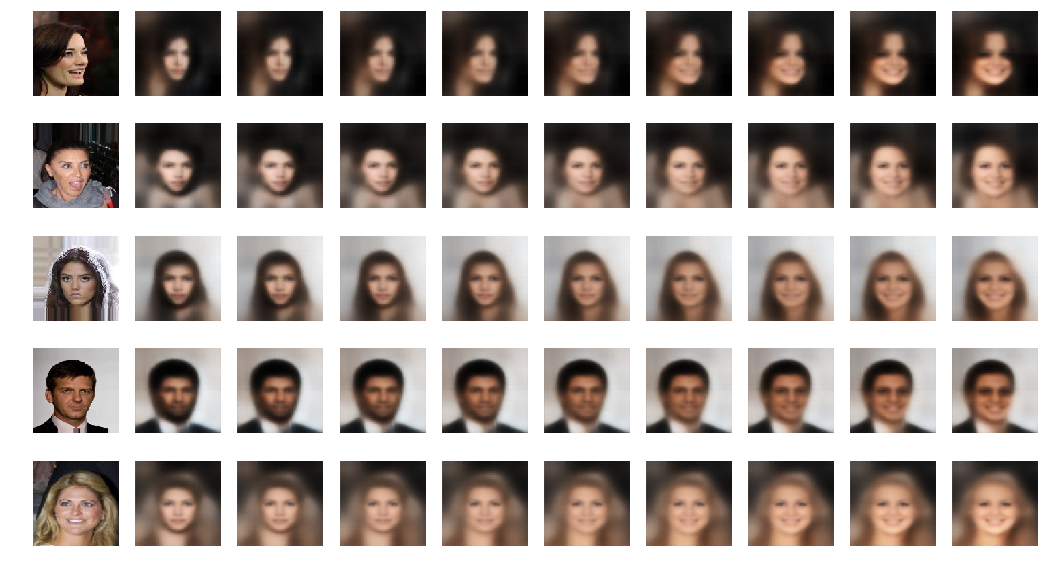

In [22]:
print('Mouth Open Vector')
add_vector_to_images(mouth_open_vec)

Smiling Vector
Found 202599 validated image filenames.


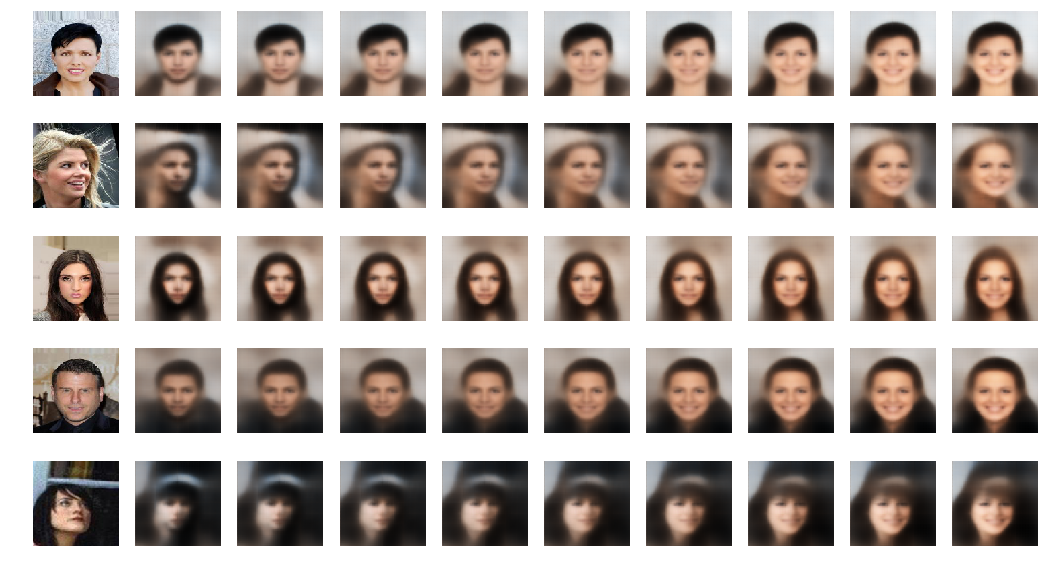

In [23]:
print('Smiling Vector')
add_vector_to_images(smiling_vec)

Lipstick Vector
Found 202599 validated image filenames.


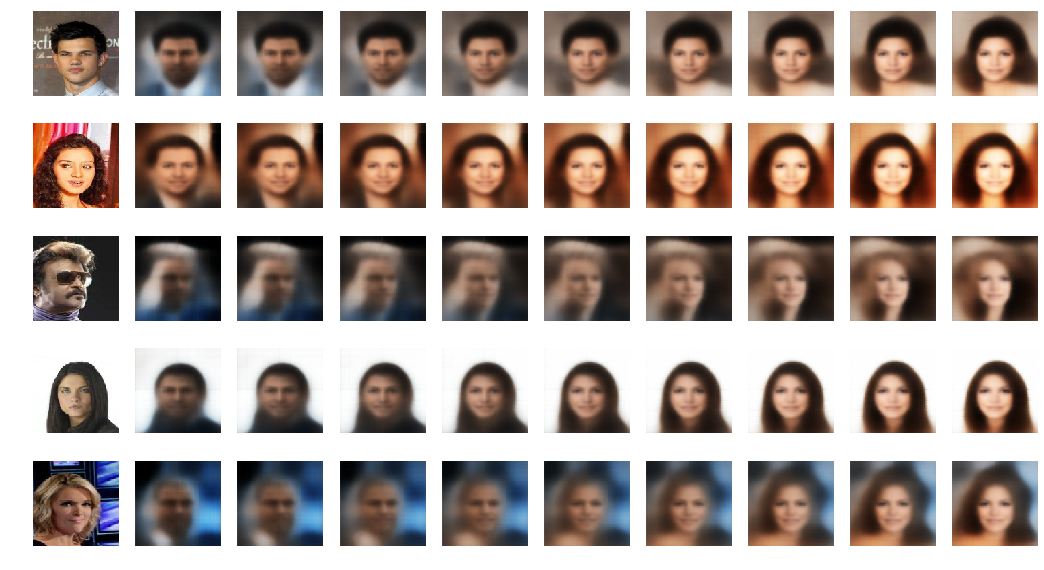

In [24]:
print('Lipstick Vector')
add_vector_to_images(lipstick_vec)

Young Vector
Found 202599 validated image filenames.


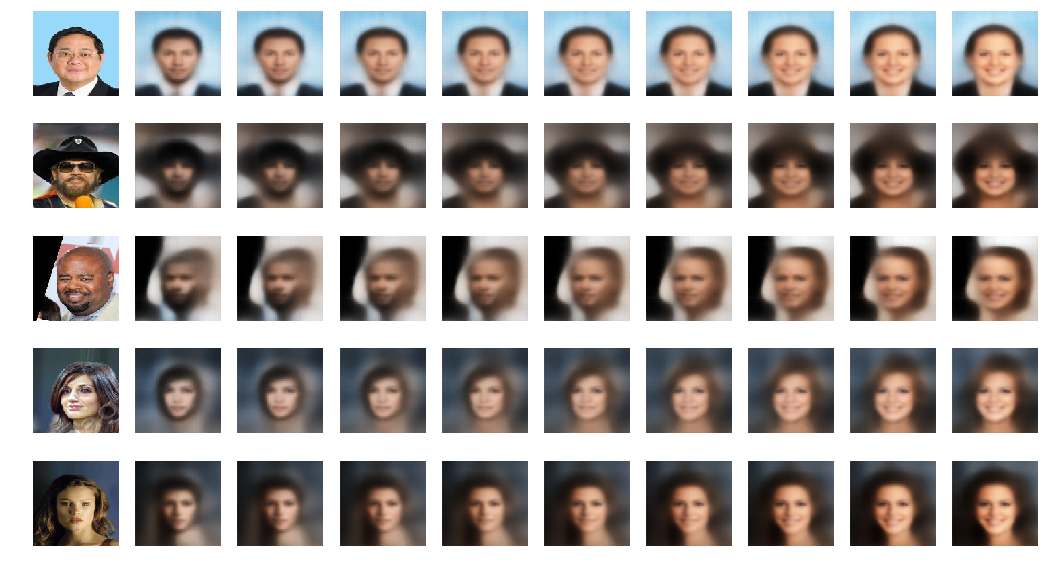

In [25]:
print('Young Vector')
add_vector_to_images(young_vec)

Blond Vector
Found 202599 validated image filenames.


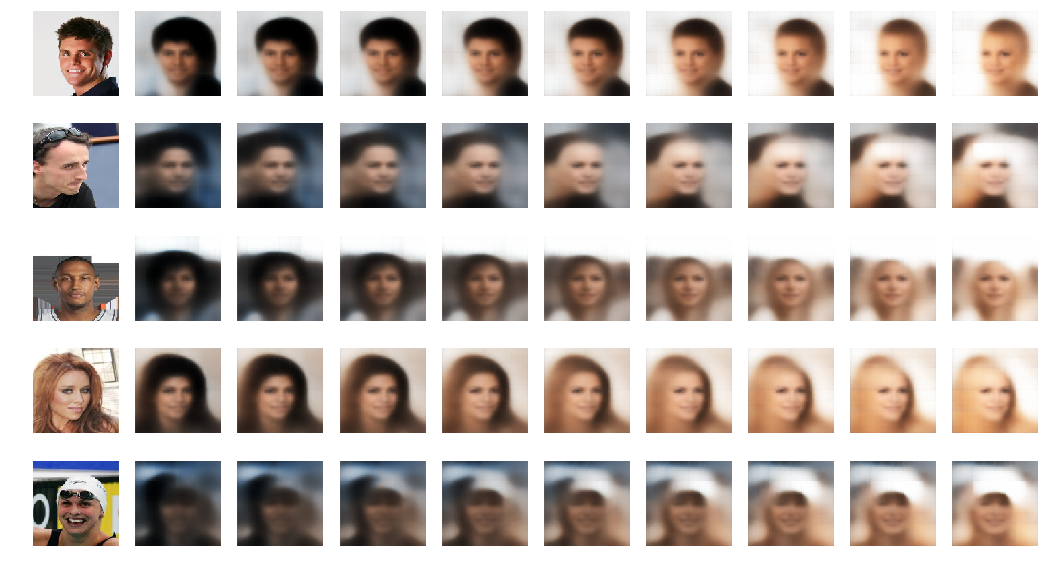

In [26]:
print('Blond Vector')
add_vector_to_images(blonde_vec)

Male Vector
Found 202599 validated image filenames.


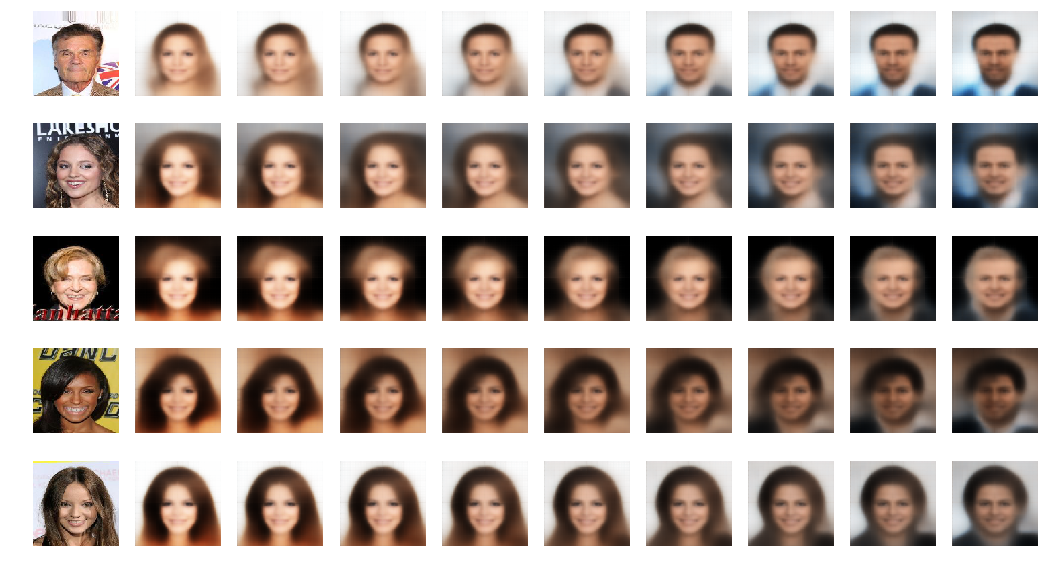

In [27]:
print('Male Vector')
add_vector_to_images(male_vec)

Eyeglasses Vector
Found 202599 validated image filenames.


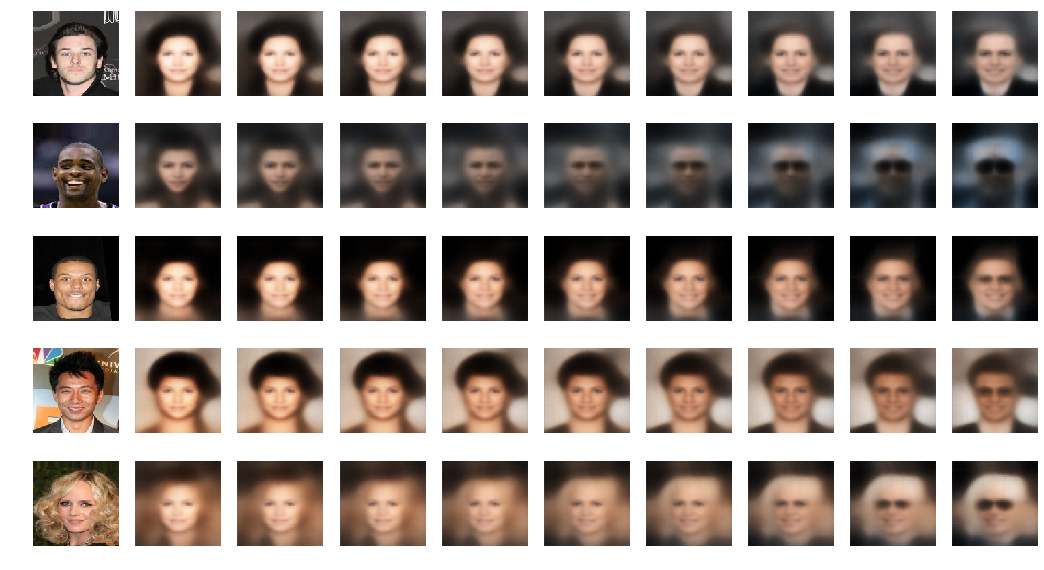

In [28]:
print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

## Face Morphing

Using a similar idea as above to morph between two faces


In [0]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    attr_specific = attr[attr['File_name'].isin([start_image_file, end_image_file])]
    attr_specific = attr_specific.reset_index()
    data_gen = ImageDataGenerator(rescale=1./255)
    data_flow_label = data_gen.flow_from_dataframe(attr_specific, IMAGE_FOLDER, 
                                                   x_col='File_name', 
                                                   target_size=INPUT_DIM[:2] , 
                                                   class_mode='input', 
                                                   batch_size=2, 
                                                   shuffle=True)
    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 validated image filenames.


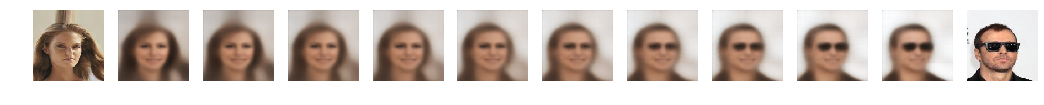

In [30]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


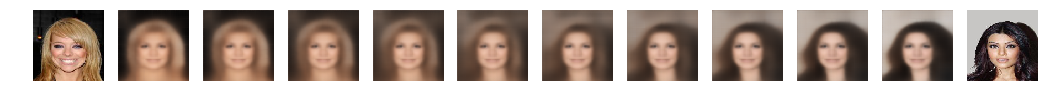

In [31]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


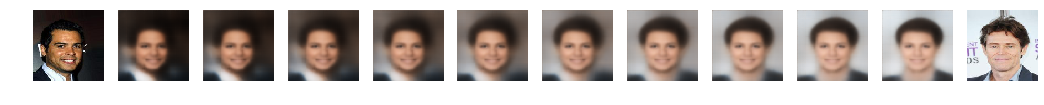

In [32]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)

**The results are not good as SOTA as this was run on colab (k80 GPU), we did try it on AWS on V100 machine but due to some technical problem the dataset was not loading on the machine and hence we had to give up. For paperspace we didn't get the V100 machine to train on. Other than results I have tried to explain everything for a better understanding of whats being done.**